# Getting Started with Cloud-Native HLS Data in Python

**Summary**

This tutorial was developed using an example use case for crop monitoring over a single large farm field in northern California. **The goal of the project is to observe HLS-derived mean EVI over a farm field in northern California without downloading the entirety of the HLS source data.** In this notebook we will extract and EVI timeseries from Harmonized Landsat Sentinel-2 (HLS) data in the Cloud using CMR's SpatioTemporal Asset Catalog (CMR-STAC).  This tutorial will show how to use the CMR-STAC API to investigate the HLS collections available in the cloud and search for and subset to the specific time period, bands (layers), and region of interest for our use case, load subsets of the desired COGs into a Jupyter Notebook directly from the cloud, quality filter and calculate EVI, stack the time series, visualize the time series, and export a CSV of statistics on the EVI of the single farm field.  

**Background**

The  Harmonized Landsat Sentinel-2 ([HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/)) project produces seamless, harmonized surface reflectance data from the Operational Land Imager (OLI) and Multi-Spectral Instrument (MSI) aboard Landsat and Sentinel-2 Earth-observing satellites, respectively. The aim is to produce seamless products with normalized parameters, which include atmospheric correction, cloud and cloud-shadow masking, geographic co-registration and common gridding, normalized bidirectional reflectance distribution function, and spectral band adjustment. This will provide global observation of the Earth’s surface every 2-3 days with 30 meter spatial resolution. One of the major applications that will benefit from HLS is agriculture assessment and monitoring, which is used as the use case for this tutorial.  

NASA's Land Processes Distributed Active Archive Center (LP DAAC) archives and distributes HLS products in the LP DAAC Cumulus cloud archive as Cloud Optimized GeoTIFFs (COG). This tutorial will demonstrate  Because these data are stored as COGs, this tutorial will teach users how to load subsets of individual files into memory for just the bands you are interested in--a paradigm shift from the more common workflow where you would need to download a .zip/HDF file containing every band over the entire scene/tile. This tutorial covers how to process HLS data (quality filtering and EVI calculation), visualize, and "stack" the scenes over a region of interest into an [xarray](http://xarray.pydata.org/en/stable/) data array, calculate statistics for an EVI time series, and export as a comma-separated values (CSV) file--providing you with all of the information you need for your area of interest without having to download the source data file. The Enhanced Vegetation Index ([EVI](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_4.php)), is a vegetation index similar to NDVI that has been found to be more sensitive to ground cover below the vegetated canopy and saturates less over areas of dense green vegetation.  

**Requirements**

- A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.
- You will will also need to have a netrc file set up in your home directory in order to successfully run the code below. A code chunk in a later section provides a way to do this, or you can check out the [setup_intstructions.md](../../python/setup/setup_instructions.md).

**Learning Objectives**

- How to work with HLS Landsat ([HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)) and Sentinel-2 ([HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)) data products
- How to query and subset HLS data using the NASA Common Metadata Repository (CMR) SpatioTemporal Asset Catalog (STAC) application programming interface (API)
- How to access and work with cloud stored HLS data 
- How to filter data using HLS quality information

**Tutorial Outline**

1. [**Getting Started**](#getstarted)  
    1.1 Import Packages         
    1.2 EarthData Login  
2. [**Finding HLS Data**](#find)            
    2.1 Subset by Band   
    2.2 Load HLS COGs into Memory  
    2.3 Subset spatially  
    2.4 Apply Scale Factor
3. [**Processing HLS Data**](#processhls)    
    3.1 Calculate EVI    
    3.2 Quality Filtering   
    3.3 Export to COG   
4. [**Automation**](#automation)     
5. [**Stacking HLS Data**](#stackhls)    
    5.1 Open and Stack COGs      
    5.2 Visualize Stacked Time Series  
6. [**Export Statistics**](#export)

**Data Used in the Example**  

- Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)
    - The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products._  
     - Science Dataset (SDS) layers: 
        - B8A (NIR Narrow)  
        - B04 (Red)  
        - B02 (Blue)  
        - Fmask (Quality)    

- Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)
    - The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products.  
     - Science Dataset (SDS) layers:
        - B05 (NIR)  
        - B04 (Red)  
        - B02 (Blue)  
        - Fmask (Quality)  

---

## 1. Getting Started<a id="getstarted"></a>

### 1.1 Import Packages 

Import the required packages.

In [1]:
import os
from datetime import datetime
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
from skimage import io
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rioy
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas
import json
import panel as pn
import cartopy
import geoviews
import earthaccess

### 1.2 EarthData Login

Use `earthaccess` to sign into your earthdata login. This function uses a local `.netrc` file to store credentials. If you do not have a `.netrc` file, you will be prompted for your credentials and one will be created. Please see more details on earthaccess Python library [here](https://github.com/nsidc/earthaccess#readme).


In [2]:
earthaccess.login(persist=True)

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 07/24/2023
Using .netrc file for EDL


## 2. Finding HLS Data<a id="find"></a>

To locate HLS data, we will use the `earthaccess` python library to search NASA's Common Metadata Repository (CMR) for HLS data. We will open a geojson file with a polygon of our ROI that we can use in our search. To do this, we will simplify it to a bounding box. Grab the bounding coordinates from the geopandas object after opening.

In [3]:
field = gp.read_file('../../data/Field_Boundary2.geojson')
bbox = (field['geometry'][0].bounds[0],field['geometry'][0].bounds[1],field['geometry'][0].bounds[2],field['geometry'][0].bounds[3])

When searching we can also search a specific time period of interest. Here we search from the beginning of May 2021 to the end of September 2021.

In [4]:
temporal = ("2021-05-01T00:00:00", "2021-09-30T23:59:59")


Since HLS is a part of 2 collections, HLSL30 and HLSS30, we will include both short names. Search using our constraints and the `count = 100` to limit our search to 100 results.

In [5]:
results = earthaccess.search_data(
    short_name=['HLSL30','HLSS30'],
    bounding_box=bbox,
    temporal=temporal, # 2021-07-15T00:00:00Z/2021-09-15T23:59:59Z
    count=100
)

Granules found: 78


We can preview these results in a dataframe like below if we want to check the metadata. Note we only show the first 5.

In [6]:
pd.json_normalize(results).head(5)

size meta.concept-type      meta.concept-id  meta.revision-id   
0     0           granule  G2153255128-LPCLOUD                 1  \
1     0           granule  G2153407526-LPCLOUD                 1   
2     0           granule  G2153881444-LPCLOUD                 1   
3     0           granule  G2144019307-LPCLOUD                 1   
4     0           granule  G2153591767-LPCLOUD                 1   

                       meta.native-id meta.provider-id   
0  HLS.S30.T10TEK.2021122T185911.v2.0          LPCLOUD  \
1  HLS.S30.T10TEK.2021124T184919.v2.0          LPCLOUD   
2  HLS.S30.T10TEK.2021127T185919.v2.0          LPCLOUD   
3  HLS.L30.T10TEK.2021128T184447.v2.0          LPCLOUD   
4  HLS.S30.T10TEK.2021129T184921.v2.0          LPCLOUD   

              meta.format        meta.revision-date   
0  application/echo10+xml  2021-10-29T10:47:01.310Z  \
1  application/echo10+xml  2021-10-29T14:09:37.033Z   
2  application/echo10+xml  2021-10-30T00:59:05.213Z   
3  application/echo10+xml  2021-10-15T03:48:08.875Z   
4  application/echo10+xml  2021-10-29T16:27:32.621Z   

  umm.TemporalExtent.RangeDateTime.BeginningDateTime   
0                           2021-05-02T19:13:19.930Z  \
1                           2021-05-04T19:03:22.997Z   
2                           2021-05-07T19:13:19.594Z   
3                           2021-05-08T18:44:47.423Z   
4                           2021-05-09T19:03:25.151Z   

  umm.TemporalExtent.RangeDateTime.EndingDateTime  ...   
0                        2021-05-02T19:13:19.930Z  ...  \
1                        2021-05-04T19:03:22.997Z  ...   
2                        2021-05-07T19:13:19.594Z  ...   
3                        2021-05-08T18:45:11.310Z  ...   
4                        2021-05-09T19:03:25.151Z  ...   

                  umm.CollectionReference.EntryTitle   
0  HLS Sentinel-2 Multi-spectral Instrument Surfa...  \
1  HLS Sentinel-2 Multi-spectral Instrument Surfa...   
2  HLS Sentinel-2 Multi-spectral Instrument Surfa...   
3  HLS Landsat Operational Land Imager Surface Re...   
4  HLS Sentinel-2 Multi-spectral Instrument Surfa...   

                                     umm.RelatedUrls   
0  [{'URL': 'https://data.lpdaac.earthdatacloud.n...  \
1  [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
2  [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
3  [{'URL': 'https://data.lpdaac.earthdatacloud.n...   
4  [{'URL': 'https://data.lpdaac.earthdatacloud.n...   

  umm.DataGranule.DayNightFlag   
0                          Day  \
1                          Day   
2                          Day   
3                          Day   
4                          Day   

                         umm.DataGranule.Identifiers   
0  [{'Identifier': 'HLS.S30.T10TEK.2021122T185911...  \
1  [{'Identifier': 'HLS.S30.T10TEK.2021124T184919...   
2  [{'Identifier': 'HLS.S30.T10TEK.2021127T185919...   
3  [{'Identifier': 'HLS.L30.T10TEK.2021128T184447...   
4  [{'Identifier': 'HLS.S30.T10TEK.2021129T184921...   

  umm.DataGranule.ProductionDateTime   
0           2021-10-29T10:44:28.000Z  \
1           2021-10-29T13:51:48.000Z   
2           2021-10-29T21:47:54.000Z   
3           2021-10-14T22:05:21.000Z   
4           2021-10-29T16:13:58.000Z   

   umm.DataGranule.ArchiveAndDistributionInformation   
0  [{'Name': 'Not provided', 'SizeInBytes': 20854...  \
1  [{'Name': 'Not provided', 'SizeInBytes': 19608...   
2  [{'Name': 'Not provided', 'SizeInBytes': 20891...   
3  [{'Name': 'Not provided', 'SizeInBytes': 10777...   
4  [{'Name': 'Not provided', 'SizeInBytes': 19603...   

                                       umm.Platforms   
0  [{'ShortName': 'Sentinel-2A', 'Instruments': [...  \
1  [{'ShortName': 'Sentinel-2B', 'Instruments': [...   
2  [{'ShortName': 'Sentinel-2B', 'Instruments': [...   
3  [{'ShortName': 'LANDSAT-8', 'Instruments': [{'...   
4  [{'ShortName': 'Sentinel-2A', 'Instruments': [...   

                       umm.MetadataSpecification.URL   
0  https://cdn.earthdata.nasa.gov/umm/gra

We can also preview each individual result by selecting it from the list. This will show the data links, and a browse image. 

In [7]:
results[0]

Collection: {'EntryTitle': 'HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance Daily Global 30m v2.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -121.96195396, 'Latitude': 39.65696806}, {'Longitude': -121.70666928, 'Latitude': 40.38335389}, {'Longitude': -121.70165934, 'Latitude': 40.64355721}, {'Longitude': -123.00023656, 'Latitude': 40.65085652}, {'Longitude': -123.00023316, 'Latitude': 39.66160696}, {'Longitude': -121.96195396, 'Latitude': 39.65696806}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-05-02T19:13:19.930Z', 'EndingDateTime': '2021-05-02T19:13:19.930Z'}}
Size(MB): 0
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B10.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B05.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.VAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B04.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B01.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B07.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B02.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B08.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.VZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B03.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B09.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B11.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B06.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B8A.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.Fmask.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.SAA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021122T185911.v2.0/HLS.S30.T10TEK.2021122T185911.v2.0.B12.tif']

We can grab all of the urls for the data and the urls for the browse images using list comprehension.

In [8]:
# Data
hls_results_urls = [granule.data_links() for granule in results]
# Browse Images 
browse_urls = [granule.dataviz_links()[0] for granule in results] # 0 retrieves only the https links

---

## 3. Extracting HLS COGs from the Cloud <a id="extracthls"></a>

Now that we have a list of URLs, we will configure `gdal` and `rioxarray` to use `vsicurl` to access the cloud assets that we are interested in, and read them directly into memory without needing to download the files. 

Accessing data stored in the Cloud is done using Python libraries that leverage GDAL's virtual file systems. Whether you are running this code in the Cloud or in a local workspace, GDAL configurations must be set in order to successfully access the HLS COG files.

In [9]:
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

## 2.1 Subset by Band 

View the contents of the first item.

In [10]:
h = hls_results_urls[10]  
h

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B12.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B10.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B01.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.Fmask.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B04.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B8A.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS

Subset by band by filtering to only include the NIR, Red, Blue, and Quality (Fmask) layers in the list of links to access. Below you can find the different band numbers for each of the two products.

### Sentinel 2:
        - "narrow" NIR = B8A
        - Red = B04
        - Blue = B02  
        - Quality = Fmask
### Landsat 8:
        - NIR = B05
        - Red = B04
        - Blue = B02  
        - Quality = Fmask

In [11]:
evi_band_links = []

# Define which HLS product is being accessed
if h[0].split('/')[4] == 'HLSS30.020':
    evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for S30
else:
    evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE Quality for L30

# Subset the assets in the item down to only the desired bands
for a in h: 
    if any(b in a for b in evi_bands):
        evi_band_links.append(a)
evi_band_links

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.Fmask.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B04.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B8A.tif',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B02.tif']

Remember from above that you can always quickly load in the browse image to get a quick view of the item using our list of browse URLs.

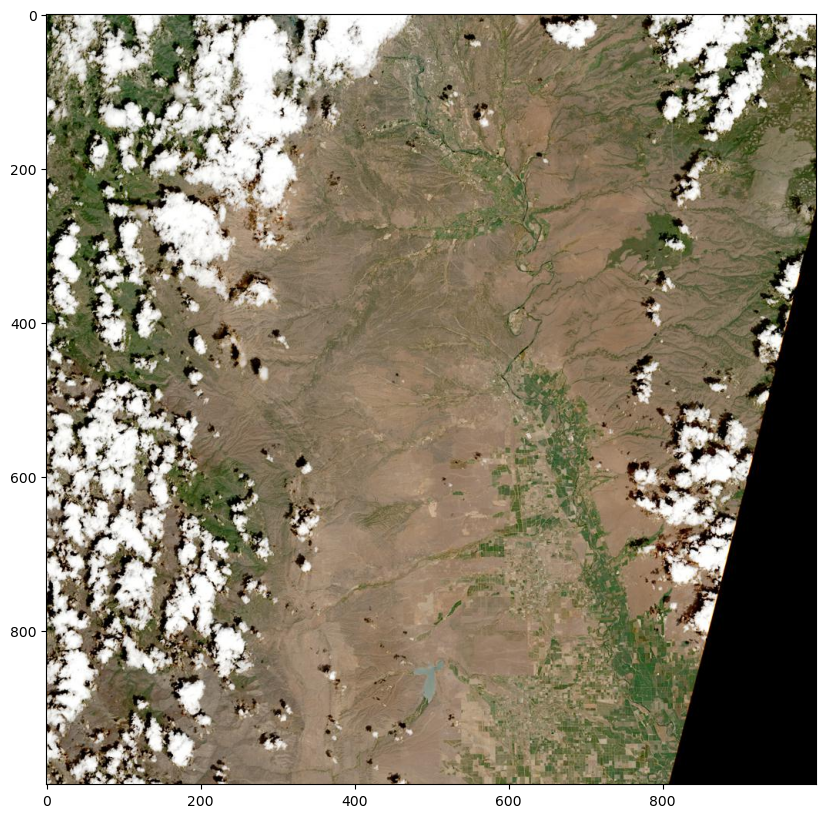

In [12]:
image = io.imread(browse_urls[10])  # Load jpg browse image into memory

# Basic plot of the image
plt.figure(figsize=(10,10))              
plt.imshow(image)
plt.show()

Above, we see our first observation over the northern Central Valley of California. 

In [13]:
del image # Remove the browse image

## 2.2 Load HLS COGs into Memory 

HLS COGs are broken into chunks allowing data to be read more efficiently without loading the entire file into memory. Define the chunk size of an HLS tile, mask the NaN values, then read the files using `rioxarray` and name them based upon the band. We also squeeze the object to remove the band dimension from most of the files, since there is only 1 band.

To scale the bands, you can set the `mask_and_scale` to `True` (`mask_and_scale=True`), however the `scale_factor` information in some of the HLSL30 granules are missing from the `Band` information and is saved in a different location in the metadata. `rioxarray` looks for the `scale_factor` under Band information and if this information is missing it assumes it is equal to 1. This results in having data to be uscaled and not masked for those granules. That is why we treat our data a bit differently, leaving it unscaled and manually updating the `scale-factor`. we'll utilize that later to scale the data. 

In [14]:
# Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
for e in evi_band_links:
    print(e)
    if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
        nir = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
        nir.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute 
    elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
        red = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
        red.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute
    elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
        blue = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
        blue.attrs['scale_factor'] = 0.0001                        # hard coded the scale_factor attribute
    elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
        fmask = rxr.open_rasterio(e, chunks=chunk_size, masked= True).astype('uint16').squeeze('band', drop=True)
print("The COGs have been loaded into memory!")

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.Fmask.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B8A.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021142T185921.v2.0/HLS.S30.T10TEK.2021142T185921.v2.0.B02.tif
The COGs have been loaded into memory!


> **NOTE:** Getting an error in the section above? Accessing these files in the cloud requires you to authenticate using your NASA Earthdata Login account. You will need to have a netrc file set up containing those credentials in your home directory in order to successfully run the code below. Please make sure you have a valid username and password in the created netrc file. 

## 2.3 Subset spatially

Below, take the farm field `geopandas` dataframe convert it from lat/lon (EPSG: 4326) into the [native projection of HLS](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-tiling-system), UTM (aligned to the Military Grid Reference System). This must be done in order to use the Region of Interest (ROI) to subset the COG that is being pulled into memory--it must be in the native projection of the data being extracted. 

In [15]:
fsUTM = field.to_crs(nir.spatial_ref.crs_wkt) # Take the CRS from the NIR tile that we opened and apply it to our field geodataframe.
fsUTM

geometry
0  POLYGON ((577198.426 4417787.075, 577464.734 4...

Now, we can use our field ROI to mask any pixels that fall outside of it and crop to the bounding box using `rasterio`. This greatly reduces the amount of data that are needed to load into memory. 

In [16]:
nir_cropped = nir.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True) # All touched includes any pixels touched by the polygon
nir_cropped

<xarray.DataArray (y: 118, x: 179)>
dask.array<getitem, shape=(118, 179), dtype=float32, chunksize=(118, 179), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * y            (y) float64 4.42e+06 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
    spatial_ref  int32 0
Attributes: (12/41)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    AREA_OR_POINT:                                     Area
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    ...                                                ...
    SPACECRAFT_NAME:                                   Sentinel-2A
    spatial_coverage:                                  92
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_VG...
    ULX:                                               499980
    ULY:                                               4500000

Now plot the cropped NIR data.

In [17]:
nir_cropped.hvplot.image(aspect='equal', cmap='viridis', frame_height=500, frame_width= 800).opts(title='HLS Cropped NIR Band')  # Quick visual to assure that it worked

:Image   [x,y]   (value)

Above, you can see that the data have been loaded into memory already subset to our ROI. Also notice that the data has not been scaled. Next, data is scaled usin the function defined below. 

## 2.4 Apply Scale Factor 

In [18]:
# Define function to scale 
def scaling(band):
    scale_factor = band.attrs['scale_factor'] 
    band_out = band.copy()
    band_out.data = band.data*scale_factor
    band_out.attrs['scale_factor'] = 1
    return(band_out)

In [19]:
nir_cropped_scaled = scaling(nir_cropped)

We can plot to confirm our manual scaling worked.

In [20]:
nir_cropped_scaled.hvplot.image(aspect='equal', cmap='viridis', frame_height=500, frame_width= 800).opts(title='HLS Cropped NIR Band')  # Quick visual to assure that it worked

:Image   [x,y]   (value)

Next, load in the red and blue bands and fix their scaling as well.

In [21]:
# Red
red_cropped = red.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
red_cropped_scaled = scaling(red_cropped)
# Blue
blue_cropped = blue.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
blue_cropped_scaled = scaling(blue_cropped)
print('Data is loaded and scaled!')

Data is loaded and scaled!


---
## 4. Processing HLS Data <a id="processhls"></a>

In this section, define a function to calculate EVI, and execute the EVI function on the data loaded into memory. After that, perform quality filtering to screen out any poor quality observations. 

### 4.1 Calculate EVI

Read the file metadata.

Define a function for calculating EVI using the NIR, Red, and Blue bands and build an `xarray.DataArray` from the NIR, Red, and Blue bands.

In [22]:
def calc_evi(red, blue, nir):
      # Create EVI xarray.DataArray that has the same coordinates and metadata
      evi = red.copy()
      # Calculate the EVI
      evi_data = 2.5 * ((nir.data - red.data) / (nir.data + 6.0 * red.data - 7.5 * blue.data + 1.0))
      # Replace the Red xarray.DataArray data with the new EVI data
      evi.data = evi_data
      # exclude the inf values
      evi = xr.where(evi != np.inf, evi, np.nan, keep_attrs=True)
      # change the long_name in the attributes
      evi.attrs['long_name'] = 'EVI'
      evi.attrs['scale_factor'] = 1
      return evi

Below, apply the EVI function on the scaled data.

In [23]:
evi_cropped = calc_evi(red_cropped_scaled, blue_cropped_scaled, nir_cropped_scaled) # Generate EVI array
evi_cropped


<xarray.DataArray (y: 118, x: 179)>
dask.array<where, shape=(118, 179), dtype=float32, chunksize=(118, 179), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * y            (y) float64 4.42e+06 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
    spatial_ref  int32 0
Attributes: (12/41)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    AREA_OR_POINT:                                     Area
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    ...                                                ...
    SPACECRAFT_NAME:                                   Sentinel-2A
    spatial_coverage:                                  92
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_VG...
    ULX:                                               499980
    ULY:                                               4500000

Next, plot the results using `hvplot`.

In [24]:
evi_cropped.hvplot.image(aspect='equal', cmap='YlGn', frame_height=500, frame_width= 800).opts(title=f'HLS-derived EVI, {evi_cropped.SENSING_TIME}', clabel='EVI')

:Image   [x,y]   (value)

Above, notice that variation of green level appearing in different fields in our ROI, some being much greener than the others. 

### 4.2 Quality Filtering <a id="2.1"></a>

In this section, load in the `Fmask` quality layer, breakdown the bit-encoded information, define good quality observations, and apply a mask to the EVI layer using pixels with good quality as defined by the `Fmask`.

In [25]:
fmask_cropped = fmask.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)  # Load in the Quality data
fmask_cropped


<xarray.DataArray (y: 118, x: 179)>
dask.array<astype, shape=(118, 179), dtype=uint16, chunksize=(118, 179), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * y            (y) float64 4.42e+06 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
    spatial_ref  int32 0
Attributes: (12/41)
    ACCODE:                                            LaSRC
    AREA_OR_POINT:                                     Area
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    arop_rmse(meters):                                 0
    ...                                                ...
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_VG...
    ULX:                                               499980
    ULY:                                               4500000
    scale_factor:                                      1.0
    add_offset:                                        0.0

The quality table above can be found in section 6.4 of the [HLS V2.0 User Guide](https://lpdaac.usgs.gov/documents/1326/HLS_User_Guide_V2.pdf).

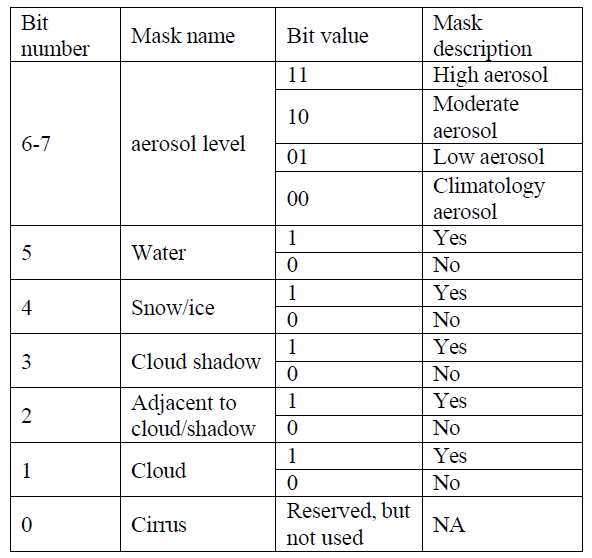


Let's look at the values in the `Fmaks` layer and decode them for easier interpretation. 

In [26]:
# define a function to interpret the mask vals
def decode_hls(val):
    bit = bin(val).split('0b')[1].rjust(8, '0')
    if bit[0:2] == '00': aerosol_level = "climotology"
    elif bit[0:2] == '10': aerosol_level = "moderate"
    elif bit[0:2] == '01': aerosol_level = "low"
    else: aerosol_level = "high"

    if bit[2] == '0': wtr = "not water"
    else: wtr = "water"
    if bit[3] == '0': snw = "not snow/ice"
    else: snw = "with snow/ice"
    if bit[4] == '0': cld_shdw = "not cloud shadow"
    else: cld_shdw = "with cloud shadow"
    if bit[5] == '0': adj = "not adjacent to cloud/shadow"
    else: adj = "adjacent to cloud/shadow"
    if bit[6] == '0': cld = "not cloud"
    else: cld = "cloud"
    print (f'Quality value {val} is: {cld}, {adj}, {cld_shdw}, {snw}, {wtr}, with {aerosol_level} aerosol level.')

Below see the unique values in our clipped `Fmask` layer and decode quality information. 

In [27]:
for numbers in np.unique(fmask_cropped):
    decode_hls(numbers)

Quality value 0 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, not snow/ice, not water, with climotology aerosol level.
Quality value 64 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, not snow/ice, not water, with low aerosol level.
Quality value 80 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, with snow/ice, not water, with low aerosol level.
Quality value 96 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, not snow/ice, water, with low aerosol level.
Quality value 112 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, with snow/ice, water, with low aerosol level.
Quality value 128 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, not snow/ice, not water, with moderate aerosol level.
Quality value 144 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, with snow/ice, not water, with moderate aerosol level.
Quality value 160 is: not cloud, not adjacent to cloud/shadow, not cloud shadow, n

c:\Users\mjami\Anaconda3\envs\hls_tutorial\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


Now that we got an idea about the quality of data, we can only keep the quality values we want.
Run the cell below, answer the questions about your desired quality filtering. If you click on cancel the quality field will not be masked. 
In this example, only `Climotology Aerosol` and `Moderate Aerosol` level is kept and everything else including water pixels are identified to be masked. 

In [28]:
# ask quwstion from user about the quality filtering layers
import easygui as eg
choices = ["Yes","No"]
cloud_mask = eg.choicebox("Do you want to mask the cloud pixels?", choices=choices)
water_mask = eg.choicebox("Do you want to mask the water pixels?", choices=choices)
snow_mask = eg.choicebox("Do you want to mask the snow/ice pixels?", choices=choices)
shadow_mask = eg.choicebox("Do you want to mask the cloud shadow pixels?", choices=choices)
adjacent_mask = eg.choicebox("Do you want to mask the pixels that are adjacent to cloud/shadow?", choices=choices)
# Select Aerosol threshold (inclusive) for what is considered too high (0 = Climate, 1 = Low, 2 = moderate, 3 = high)
aerosol_mask = eg.multchoicebox("What aerosol level(s) do you want to mask? (you can select multiple choices)" , "Aerosol Level", ["Climotology", "Low", "Moderate", "High"])
    

Functions are defined to identify your desire quality mask and masking those values. 

If you are willing to keep all the quality values, you can skip this step and move on to the next section. 

In [29]:
def quality_val (fmask, cloud_mask, water_mask, snow_mask, shadow_mask, adjacent_mask, aerosol_mask):
    
    # create a list of bit values
    bit_nums = []
    if cloud_mask == 'Yes': bit_nums.append(1)
    if water_mask == 'Yes': bit_nums.append(5)
    if snow_mask == 'Yes': bit_nums.append(4)
    if shadow_mask == 'Yes': bit_nums.append(3)
    if adjacent_mask == 'Yes': bit_nums.append(2)
    # handle the case that user click the cancel option for aerosol level
    if str(aerosol_mask) == 'None': aerosol_val = []
    else: aerosol_val = aerosol_mask
    aerosol_quality_val = []
    if "Low" in aerosol_val: aerosol_quality_val.append([6])
    if "Moderate" in aerosol_val: aerosol_quality_val.append([7])
    if "High" in aerosol_val: aerosol_quality_val.append([6,7])

    # Function is defined to avoid repetative code
    def masking(fmask, bits, logic):
      mask_array = np.zeros((fmask.shape[0], fmask.shape[1]))
      for b in bits:
         mask_temp = np.array(fmask) & 1 << b > 0
         if logic == "or":
            mask_array = np.logical_or(mask_array , mask_temp)
         elif logic == "and":
            mask_array = np.logical_and(mask_array , mask_temp)
      return(mask_array)

    # create a mask array for bit 0-5
    if len(bit_nums) == 1: mask_array = np.array(fmask) & 1 << bit_nums[0] > 0 #[3]
    elif len(bit_nums) > 1: # [2,3,4]
      mask_array = masking(fmask, bit_nums, 'or')
    
    # create a mask array for bit 6 and 7
    if len(aerosol_quality_val) == 1: 
      if len(aerosol_quality_val[0]) == 1: #[[6]] 
         mask_array_aero =  np.array(fmask) & 1 << aerosol_quality_val[0][0] > 0
      else: # [[6,7]]
         mask_array_aero = masking(fmask, aerosol_quality_val[0], 'and' )

    elif len(aerosol_quality_val) > 1: # [[6], [6,7]]
      mask_array_aero = np.zeros((fmask.shape[0], fmask.shape[1]))
      for a in aerosol_quality_val:
         if len(a) == 1: 
            mask_temp_aero =  np.array(fmask) & 1 << a[0] > 0
            mask_array_aero = np.logical_or(mask_array_aero , mask_temp_aero)
         else:
            mask_array_aero = masking(fmask, a,'and')

      
    # combine two mask arrays to include them all
    mask_final = np.logical_or(mask_array, mask_array_aero)
    return(mask_final)



def apply_mask(datasets, mask_final):
   output = datasets.copy()
   datasets_masked = np.ma.MaskedArray(datasets, mask = mask_final) # Apply QA mask to the ST data
   datasets_masked = np.ma.filled(datasets_masked, np.nan)
   output.data = datasets_masked
   return(output)




Below, `quality_val` function to create a mask layer for our qualiity selection.

In [30]:
quality_mask_array = quality_val(fmask_cropped, cloud_mask, water_mask, snow_mask, shadow_mask, adjacent_mask, aerosol_mask)


#### Apply the mask to our `xarray.Dataset`

Apply the mask and plot the masked and non-masked EVI side by side.

In [31]:
evi_masked = apply_mask(evi_cropped, quality_mask_array)

In [32]:
# Apply Mask
evi_masked.hvplot.image(aspect='equal', cmap='YlGn', frame_height=300, frame_width= 400).opts(title='Masked EVI') + evi_cropped.hvplot.image(aspect='equal', cmap='YlGn', frame_height=300, frame_width= 400).opts(title='EVI')

:Layout
   .Image.I  :Image   [x,y]   (value)
   .Image.II :Image   [x,y]   (value)

Above we can clearly see the water pixels of our ROI has been masked out.

### 5 Export to COG 

In this section, create an output filename and export the quality filtered EVI to COG. 

In [33]:
original_name = evi_band_links[0].split('/')[-1]
original_name

'HLS.S30.T10TEK.2021142T185921.v2.0.Fmask.tif'

The standard format  for HLS S30 V2.0 and HLS L30 V2.0 filenames is as follows:
> **HLS.S30/HLS.L30**: Product Short Name    
**T10TEK**: MGRS Tile ID (T+5-digits)  
**2020273T190109**: Julian Date and Time of Acquisition (YYYYDDDTHHMMSS)  
**v2.0**: Product Version   
**B8A/B05**: Spectral Band  
**.tif**: Data Format (Cloud Optimized GeoTIFF)  

For additional information on HLS naming conventions, be sure to check out the [HLS Overview Page](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/#hls-naming-conventions).

Now modify the filename to describe that its EVI, cropped to an ROI and masked.

In [34]:
out_name = f"{original_name.split('v2.0')[0]}v2.0_EVI_cropped_masked.tif"  # Generate output name from the original filename
out_name

'HLS.S30.T10TEK.2021142T185921.v2.0_EVI_cropped_masked.tif'

Use the `COG` driver to write a local raster output. A cloud-optimized geotiff (COG) is a geotiff file that has been tiled and includes overviews so it can be accessed and previewed without having to load the entire image into memory at once.

In [35]:
out_folder = '../../data/'
evi_masked.rio.to_raster(raster_path=f'{out_folder}{out_name}', driver='COG')

In [36]:
# del evi_masked, evi_cropped, out_folder, out_name, fmask_cropped, red_cropped, blue_cropped, nir_cropped, red_cropped_scaled, blue_cropped_scaled, nir_cropped_scaled

---

## 5. Automation <a id="automation"></a>

In this section, automate sections 4-5 for each HLS item that intersects our spatiotemporal subset of interest. Loop through each item and subset to the desired bands, load the spatial subset into memory, apply the scale factor, calculate EVI, quality filter, and export as a Cloud Optimized GeoTIFF. 

In [37]:
len(hls_results_urls)

78

Now put it all together and loop through each of the files, visualize and export cropped and masked EVI files. 
Be patient with the for loop below, it may take a few minutes to complete. 

In [38]:

for j, h in enumerate(hls_results_urls):
    
    outName = h[0].split('/')[-1].split('v2.0')[0] +'v2.0_EVI_cropped_masked.tif'
    print(outName)

    evi_band_links = []
    if h[0].split('/')[4] == 'HLSS30.020':
        evi_bands = ['B8A', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
    else:
        evi_bands = ['B05', 'B04', 'B02', 'Fmask'] # NIR RED BLUE FMASK
    
    for a in h: 
        if any(b in a for b in evi_bands):
            evi_band_links.append(a)

    
    # Check if file already exists in output directory, if yes--skip that file and move to the next observation
    if os.path.exists(f'../../data/{outName}'):
        print(f"{outName} has already been processed and is available in this directory, moving to next file.")
        continue
    
    # Use vsicurl to load the data directly into memory (be patient, may take a few seconds)
    chunk_size = dict(band=1, x=512, y=512) # Tiles have 1 band and are divided into 512x512 pixel chunks
    for e in evi_band_links:
        print(e)
        if e.rsplit('.', 2)[-2] == evi_bands[0]:      # NIR index
            nir = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
            nir.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute 
        elif e.rsplit('.', 2)[-2] == evi_bands[1]:    # red index
            red = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
            red.attrs['scale_factor'] = 0.0001                         # hard coded the scale_factor attribute
        elif e.rsplit('.', 2)[-2] == evi_bands[2]:    # blue index
            blue = rxr.open_rasterio(e, chunks=chunk_size, masked= True).squeeze('band', drop=True)
            blue.attrs['scale_factor'] = 0.0001                        # hard coded the scale_factor attribute
        elif e.rsplit('.', 2)[-2] == evi_bands[3]:    # Fmask index
            fmask = rxr.open_rasterio(e, chunks=chunk_size, masked= True).astype('uint16').squeeze('band', drop=True)

         
    print("The COGs have been loaded into memory!")
    
    fsUTM = field.to_crs(nir.spatial_ref.crs_wkt)

    # Crop to our ROI and apply scaling and masking
    nir_cropped = nir.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    red_cropped = red.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    blue_cropped = blue.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    fmask_cropped = fmask.rio.clip(fsUTM.geometry.values, fsUTM.crs, all_touched=True)
    
    print('Cropped')      
    
    # Fix Scaling
    nir_cropped_scaled = scaling(nir_cropped)
    red_cropped_scaled = scaling(red_cropped)
    blue_cropped_scaled = scaling(blue_cropped)


    # Generate EVI
    
    evi_cropped = calc_evi(red_cropped_scaled, blue_cropped_scaled, nir_cropped_scaled)

    print('EVI Calculated')
    
    # Quality Filter the data
    quality_mask_array = quality_val(fmask_cropped, cloud_mask, water_mask, snow_mask, shadow_mask, adjacent_mask, aerosol_mask)
    evi_masked = apply_mask(evi_cropped, quality_mask_array)
    

    print('Masking Complete')

    # Remove any observations that are entirely fill value
    if np.nansum(evi_masked.data) == 0.0:
        print(f"File: {h[0].split('/')[-1].rsplit('.', 1)[0]} was entirely fill values and will not be exported.")
        continue
        
    evi_masked.rio.to_raster(raster_path=f'../../data/{outName}', driver='COG')
    
    print(f"Processing file {j+1} of {len(hls_results_urls)}")
    

HLS.S30.T10TEK.2021122T185911.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021122T185911.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021124T184919.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021124T184919.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021127T185919.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021127T185919.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.L30.T10TEK.2021128T184447.v2.0_EVI_cropped_masked.tif
HLS.L30.T10TEK.2021128T184447.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021129T184921.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021129T184921.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.


c:\Users\mjami\Anaconda3\envs\hls_tutorial\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


Masking Complete
File: HLS.S30.T10TEK.2021227T185919.v2.0.B11 was entirely fill values and will not be exported.
HLS.S30.T10TEK.2021229T184921.v2.0_EVI_cropped_masked.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021229T184921.v2.0/HLS.S30.T10TEK.2021229T184921.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021229T184921.v2.0/HLS.S30.T10TEK.2021229T184921.v2.0.B8A.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021229T184921.v2.0/HLS.S30.T10TEK.2021229T184921.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10TEK.2021229T184921.v2.0/HLS.S30.T10TEK.2021229T184921.v2.0.Fmask.tif
The COGs have been loaded into memory!
Cropped
EVI Calculated


c:\Users\mjami\Anaconda3\envs\hls_tutorial\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


Masking Complete
File: HLS.S30.T10TEK.2021229T184921.v2.0.VAA was entirely fill values and will not be exported.
HLS.L30.T10TEK.2021231T185137.v2.0_EVI_cropped_masked.tif
HLS.L30.T10TEK.2021231T185137.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021232T185921.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021232T185921.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021234T184919.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021234T184919.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021237T185919.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021237T185919.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021239T184921.v2.0_EVI_cropped_masked.tif
https://data.lpdaac.earthdata

c:\Users\mjami\Anaconda3\envs\hls_tutorial\lib\site-packages\dask\array\chunk.py:276: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


Masking Complete
File: HLS.S30.T10TEK.2021239T184921.v2.0.B05 was entirely fill values and will not be exported.
HLS.L30.T10TEK.2021240T184529.v2.0_EVI_cropped_masked.tif
HLS.L30.T10TEK.2021240T184529.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021242T185921.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021242T185921.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021244T184919.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021244T184919.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.L30.T10TEK.2021247T185142.v2.0_EVI_cropped_masked.tif
HLS.L30.T10TEK.2021247T185142.v2.0_EVI_cropped_masked.tif has already been processed and is available in this directory, moving to next file.
HLS.S30.T10TEK.2021247T185909.v2.0_EVI_cropped_masked.tif
HLS.S30.T10TEK.2021247T185909

Now there should be multiple COGs exported to your working directory, that will be used in Section 6 to stack into a time series. 

---

## 6. Stacking HLS Data <a id="stackhls"></a>

In this section we will open multiple HLS-derived EVI COGs and stack them into an `xarray` data array along the time dimension. First list the files we created in the `/data/` directory.

### 6.1 Open and Stack COGs

In [39]:
evi_dir = '../../data/'
evi_files = [os.path.abspath(os.path.join(evi_dir, o)) for o in os.listdir(evi_dir) if o.endswith('EVI_cropped_masked.tif')]  # List EVI COGs
evi_files

['C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021128T184447.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021135T185103.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021144T184457.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021151T185112.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021160T184505.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021167T185118.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021176T184509.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data\\HLS.L30.T10TEK.2021183T185121.v2.0_EVI_cropped_masked.tif',
 'C:\\Users\\mjami\\Repository\\HLS-Data-Resources\\data

Create a time index as an xarray variable from the filenames.

In [40]:
def time_index_from_filenames(evi_files):
    '''
    Helper function to create a pandas DatetimeIndex
    '''
    return [datetime.strptime(f.split('.')[-4], '%Y%jT%H%M%S') for f in evi_files]

time = xr.Variable('time', time_index_from_filenames(evi_files))

Next, the cropped and quality filtered HLS COG files are being read using `rioxarray` and a time series stack is created using `xarray`. 

In [41]:
chunks=dict(band=1, x=512, y=512)

evi_ts = xr.concat([rxr.open_rasterio(f, mask_and_scale=True, chunks=chunks).squeeze('band', drop=True) for f in evi_files], dim=time)
evi_ts.name = 'EVI'

In [42]:
evi_ts = evi_ts.sortby(evi_ts.time)
evi_ts

<xarray.DataArray 'EVI' (time: 75, y: 118, x: 179)>
dask.array<getitem, shape=(75, 118, 179), dtype=float32, chunksize=(1, 118, 179), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * y            (y) float64 4.42e+06 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2021-05-02T18:59:11 ... 2021-09-29T19:...
Attributes: (12/33)
    ACCODE:                    Lasrc; Lasrc
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    ...                        ...
    SPATIAL_RESOLUTION:        30
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       499980
    ULY:                       4500000
    USGS_SOFTWARE:             LPGS_15.4.0

### 6.2 Visualize Stacked Time Series

Below, use the [`hvPlot`](https://hvplot.pyviz.org/index.html) and [`holoviews`](https://www.holoviews.org/) packages to create an interactive time series plot of the HLS derived EVI data.Basemap layer is also added to provide better context of the areas surrounding our region of interest.

In [51]:
# set the x, y, and z (groupby) dimensions, add a colormap/bar and other parameters.

title = 'HLS-derived EVI over agricultural fields in northern California'
evi_ts.hvplot.image(x='x', y='y', groupby = 'time', frame_height=500, frame_width= 800, cmap='YlGn', geo=True, tiles = 'EsriImagery',)

:DynamicMap   [time]
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (EVI)

Looking at the time series above, the farm fields are pretty stable in terms of EVI during our temporal range. The slow decrease in EVI as we move toward Fall season could show these fields are having some sort of trees rather than crops. I encourage you to expand your temporal range to learn more about the EVI annual and seasonal changes. 

Since the data is in an xarray we can intuitively slice or reduce the dataset. Let's select a single time slice from the EVI variable.

You can use slicing to plot data only for a specific observation, for example.

In [44]:
title = 'HLS-derived EVI over agricultural fields in northern California'
# evi_cropped.hvplot.image(aspect='equal', cmap='YlGn', frame_width=300).opts(title=f'HLS-derived EVI, {evi_cropped.SENSING_TIME}', clabel='EVI')

evi_ts.isel(time=1).hvplot.image(x='x', y='y', cmap='YlGn', geo=True, tiles = 'EsriImagery', frame_height=500, frame_width= 800).opts(title=f'{title}, {evi_ts.isel(time=4).SENSING_TIME}')


c:\Users\mjami\Anaconda3\envs\hls_tutorial\lib\site-packages\osgeo\osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


:Overlay
   .Tiles.I :Tiles   [x,y]
   .Image.I :Image   [x,y]   (EVI)

Now, plot the time series as boxplots showing the distribution of EVI values for our farm field.

In [45]:
evi_ts.hvplot.box('EVI', by=['time'], rot=90, box_fill_color='lightblue', width=1000, height=600)

:BoxWhisker   [time]   (EVI)

The statistics shows a relatively stable green status in these fields during mid May to the end of September 2021. 

## 7. Export Statistics<a id="export"></a>

Next, calculate statistics for each observation and export to CSV. 

In [46]:
# xarray allows you to easily calculate a number of statistics
evi_min = evi_ts.min(('y', 'x'))
evi_max = evi_ts.max(('y', 'x'))
evi_mean = evi_ts.mean(('y', 'x'))
evi_sd = evi_ts.std(('y', 'x'))
evi_count = evi_ts.count(('y', 'x'))
evi_median = evi_ts.median(('y', 'x'))

We now have the `mean` and `standard deviation` for each time slice as well as the `maximum` and `minimum` values. Let's do some plotting! We will use the [`hvPlot`](https://hvplot.pyviz.org/index.html) package to create simple but interactive charts/plots. Hover your curser over the visualization to see the data values. 

In [47]:
evi_mean.hvplot.line()

:Curve   [time]   (EVI)

In [48]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Combine line plots for different statistics
stats = (evi_mean.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Mean')+ 
    evi_sd.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Standard Deviation')
    + evi_max.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Max') + 
    evi_min.hvplot.line(height=350, width=450, line_width=1.5, color='red', grid=True, padding=0.05).opts(title='Min')).cols(2)
stats

:Layout
   .Curve.I   :Curve   [time]   (EVI)
   .Curve.II  :Curve   [time]   (EVI)
   .Curve.III :Curve   [time]   (EVI)
   .Curve.IV  :Curve   [time]   (EVI)

Remember that these graphs are also interactive--hover over the line to see the value for a given date. 

Finally, create a `pandas` dataframe with the statistics, and export to a CSV file. 

In [49]:
# Create pandas dataframe from dictionary
df = pd.DataFrame({'Min EVI': evi_min, 'Max EVI': evi_max, 
                   'Mean EVI': evi_mean, 'Standard Deviation EVI': evi_sd, 
                   'Median EVI': evi_median, 'Count': evi_count})

In [50]:
df.index = evi_ts.time.data                       # Set the observation date as the index
df.to_csv('../../data/HLS-Derived_EVI_Stats.csv', index=True)  # Export to CSV

Success! You have now not only learned how to get started with HLS V2.0 data, but have also learned how to navigate cloud-native data using STAC, how to access subsets of COGs, and how to write COGs for your own outputs. Using this jupyter notebook as a workflow, you should now be able to switch to your specific region of interest and re-run the notebook. Good Luck!

## Contact Info  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 06-02-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 